In [2]:
import numpy as np
import bisect
import matplotlib.pyplot as plt
import sncosmo
#	astropy
from astropy.io import ascii
from astropy import units as u
from astropy import constants as const
from astropy.table import Table, vstack, hstack
#	speclite
import speclite.filters
import speclite.redshift

In [3]:
import matplotlib as mpl
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [4]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import convert_app2abs
from helper import get_wollaeger
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom


In [5]:
xl, xr = 3000, 10000 # [A]

## Get SN model
- hsiao : Type Ia SN

In [6]:
source = sncosmo.get_source('hsiao', version='3.0')
# source = sncosmo.get_source('snf-2011fe', version='1.0')
model = sncosmo.Model(source=source)
# model.set(z=8.04e-4)
# model.set_source_peakabsmag(-19.0, 'bessellb', 'ab')
model.set_source_peakmag(9.9, 'bessellv', 'ab')


In [7]:
print(model)

source:
  class      : TimeSeriesSource
  name       : 'hsiao'
  version    : 3.0
  phases     : [-20, .., 85] days
  wavelengths: [1000, .., 25000] Angstroms
parameters:
  z         = 0.0
  t0        = 0.0
  amplitude = 0.00011249224368249953


In [8]:
tmin = model.mintime()
tmax = model.maxtime()
lmin = model.minwave()
lmax = model.maxwave()

print(f't          : {tmin}-{tmax} days')
print(f'wavelength : {lmin}-{lmax} A')

t          : -20.0-85.0 days
wavelength : 1000.0-25000.0 A


- flux [erg/s/cm2/AA]

Text(0, 0.5, 'Flux [$\\rm erg/s/cm^{2}/\\AA$]')

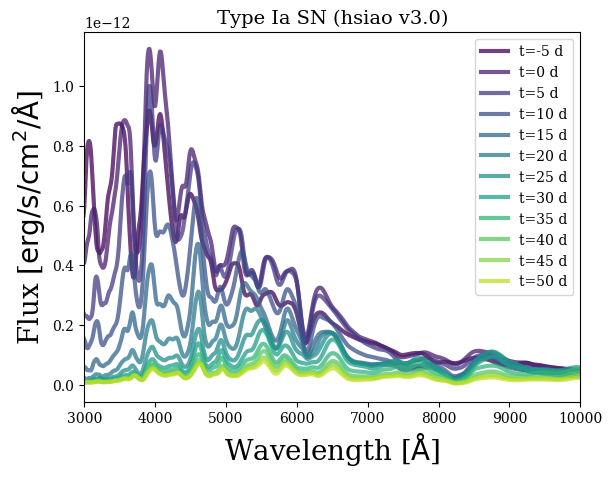

In [9]:
#	Wavelength
wavestep = 10
wave = np.arange(lmin, lmax+wavestep, wavestep)
# wave = np.arange(4000, 9000+wavestep, wavestep)

#	Time
timestep = 1
times = np.arange(-5, 50+5, 5)
t = -5

colors = makeSpecColors(len(times), palette='viridis')

plt.title(f"Type Ia SN (hsiao v3.0)")
for tt, t in enumerate(times):
	#	Model
	flux = model.flux(t, wave)
	#	Plot
	plt.plot(wave, flux, c=colors[tt], lw=3, alpha=0.75, label=f"t={t} d")

plt.xlim([xl, xr])
plt.legend()
plt.xlabel('Wavelength'+r' [$\rm \AA$]')
plt.ylabel(r'Flux [$\rm erg/s/cm^{2}/\AA$]')

Text(0, 0.5, 'App. mag [AB]')

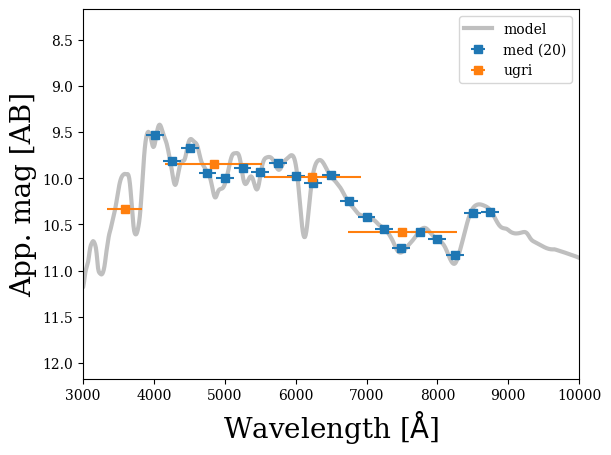

In [10]:
flux = model.flux(0, wave)
fnu = convert_flam2fnu(flux*(u.erg/u.second/u.Angstrom/u.cm**2), wave*u.Angstrom)
abmag = fnu.to(u.ABmag)

#	Med-bands
mmags = meds.get_ab_magnitudes(flux, wave)
medmag = mmags.as_array().item()*u.ABmag

mean_mag = np.mean(list(mmags.as_array().item()))
yl, yu = mean_mag-2, mean_mag+2

#	SDSS
smags = sdss.get_ab_magnitudes(flux, wave)
sdssmag = smags.as_array().item()*u.ABmag

plt.plot(wave, abmag, c='grey', lw=3, alpha=0.5, label='model')
plt.errorbar(mlam, medmag, xerr=mbdw/2, marker='s', ls='none', label=f'med ({len(medmag)})')
plt.errorbar(slam, sdssmag, xerr=sbdw/2, marker='s', ls='none', label='ugri')

plt.xlim([xl, xr])
plt.ylim([yu, yl])
plt.legend()
plt.xlabel('Wavelength'+r' [$\rm \AA$]')
plt.ylabel('App. mag [AB]')

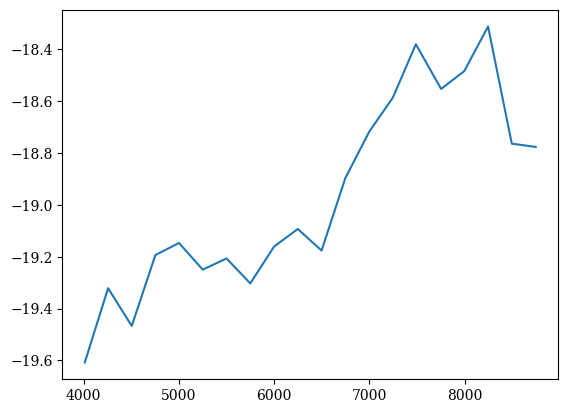

In [13]:
d = 6.73*u.Mpc
abmag_abs = convert_app2abs(medmag.value, d.to(u.pc).value)
plt.plot(mlam, abmag_abs,)

# Bulk iteration

In [30]:
path_model = '../3.table/sn_sim_sncosmo_synphot'
if ~os.path.exists(path_model): os.system(f"mkdir {path_model}")

mkdir: ../3.table/sn_sim_sncosmo_synphot: File exists


In [31]:
phtbl = Table()
phtbl['t'] = times*u.day
for filte in bdwtbl['filter'][bdwtbl['group']=='Med']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag

#	Wavelength
wavestep = 10
wave = np.arange(lmin, lmax+wavestep, wavestep)

#	Time
timestep = 1
times = np.arange(-5, 50+timestep, timestep)

for tt, t in enumerate(times):
	#	Model
	flux = model.flux(t, wave)

	#	Med-bands
	mmags = meds.get_ab_magnitudes(flux, wave)

	#	SDSS
	# smags = sdss.get_ab_magnitudes(flux, wave)
	# sdssmag = smags.as_array().item()*u.ABmag

	for key in mmags.keys():
		medmag = mmags[key].item()
		absmedmag = convert_app2abs(medmag, d.to(u.pc).value)

		filte = key.split('-')[-1]
		phtbl[f"{filte}"][tt] = absmedmag

phtbl.meta['classification'] = 'Type Ia SN'
phtbl.meta['author'] = 'hsaio+7'
phtbl.meta['distance[Mpc]'] = 6.73
phtbl.meta['peak_app_Bmag'] = 9.9

newfile = 'hsaio_v3_type_1a_sn_synphot_med.ecsv'
phtbl.write(f"{path_model}/{newfile}", format='ascii.ecsv', overwrite=True)
phtbl[:3]

t,m400,m425,m450,m475,m500,m525,m550,m575,m600,m625,m650,m675,m700,m725,m750,m775,m800,m825,m850,m875
d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
-5.0,-19.399,-19.097,-19.256,-18.986,-18.917,-18.979,-18.910,-18.970,-18.803,-18.825,-18.916,-18.749,-18.668,-18.589,-18.460,-18.528,-18.291,-18.321,-18.555,-18.511
-4.0,-19.474,-19.189,-19.352,-19.078,-19.002,-19.072,-19.004,-19.072,-18.906,-18.912,-19.008,-18.811,-18.714,-18.623,-18.468,-18.569,-18.390,-18.354,-18.641,-18.589
-3.0,-19.558,-19.252,-19.389,-19.110,-19.051,-19.141,-19.087,-19.160,-18.990,-18.984,-19.081,-18.844,-18.725,-18.624,-18.454,-18.597,-18.480,-18.358,-18.702,-18.626


In [35]:

phtbl = Table()
phtbl['t'] = times*u.day
for filte in bdwtbl['filter'][bdwtbl['group']=='SDSS']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag

#	Wavelength
wavestep = 10
wave = np.arange(lmin, lmax+wavestep, wavestep)

#	Time
timestep = 1
times = np.arange(-5, 50+timestep, timestep)

for tt, t in enumerate(times):
	#	Model
	flux = model.flux(t, wave)

	#	Med-bands
	# mmags = meds.get_ab_magnitudes(flux, wave)

	#	SDSS
	smags = sdss.get_ab_magnitudes(flux, wave)

	for key in smags.keys():
		sdssmag = smags[key].item()
		abssdssmag = convert_app2abs(sdssmag, d.to(u.pc).value)

		filte = key.split('-')[-1]
		phtbl[f"{filte}"][tt] = abssdssmag

phtbl.meta['classification'] = 'Type Ia SN'
phtbl.meta['author'] = 'hsaio+7'
phtbl.meta['distance[Mpc]'] = 6.73
phtbl.meta['peak_app_Bmag'] = 9.9

newfile = 'hsaio_v3_type_1a_sn_synphot_sdss.ecsv'
phtbl.write(f"{path_model}/{newfile}", format='ascii.ecsv', overwrite=True)

phtbl[:3]

t,g,i,r,u
d,mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64
-5.0,-19.060,-18.533,-18.862,-18.800
-4.0,-19.151,-18.574,-18.954,-18.846
-3.0,-19.204,-18.589,-19.028,-18.858


In [36]:

phtbl = Table()
phtbl['t'] = times*u.day
for filte in bdwtbl['filter'][bdwtbl['group']=='Johnson Cousin']:
	phtbl[f"{filte}"] = 0.0
	phtbl[f"{filte}"].format = '1.3f'
	phtbl[f"{filte}"].unit = u.ABmag

#	Wavelength
wavestep = 10
wave = np.arange(lmin, lmax+wavestep, wavestep)

#	Time
timestep = 1
times = np.arange(-5, 50+timestep, timestep)

for tt, t in enumerate(times):
	#	Model
	flux = model.flux(t, wave)

	#	Med-bands
	# mmags = meds.get_ab_magnitudes(flux, wave)

	#	SDSS
	# smags = sdss.get_ab_magnitudes(flux, wave)

	#	BVRI
	jcmags = jc.get_ab_magnitudes(flux, wave)


	for key in jcmags.keys():
		jcmag = jcmags[key].item()
		absjcmag = convert_app2abs(jcmag, d.to(u.pc).value)

		filte = key.split('-')[-1]
		phtbl[f"{filte}"][tt] = absjcmag

phtbl.meta['classification'] = 'Type Ia SN'
phtbl.meta['author'] = 'hsaio+7'
phtbl.meta['distance[Mpc]'] = 6.73
phtbl.meta['peak_app_Bmag'] = 9.9

newfile = 'hsaio_v3_type_1a_sn_synphot_jc.ecsv'
phtbl.write(f"{path_model}/{newfile}", format='ascii.ecsv', overwrite=True)

phtbl[:3]

t,B,V,R,I
d,mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64
-5.0,-19.150,-18.953,-18.782,-18.455
-4.0,-19.240,-19.050,-18.858,-18.510
-3.0,-19.291,-19.132,-18.913,-18.541
